In [1]:
%matplotlib inline
#import sys, traceback
import cv2
from PIL import Image
import imutils
import csv
import re
#import zbarlight
#import numpy as np
import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use("TkAgg")
from plantcv import plantcv as pcv

pcv.params.debug = 'plot'                     # Plot debug images to the notebook


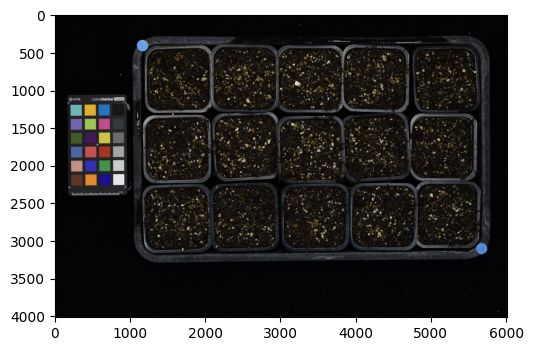

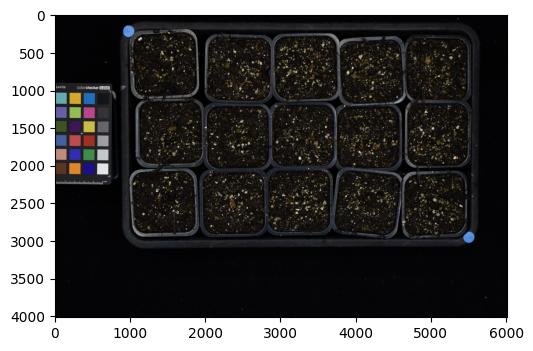

In [2]:
### Main pipeline

# Read image
img, path, filename = pcv.readimage("/home/leonard/Documents/Uni/PhD/Phenotyping/2020-05_lac11_segregating/20200527_2.JPG")    
# Read ref image
ref_img, ref_path, ref_filename = pcv.readimage("/home/leonard/Documents/Uni/PhD/Phenotyping/2020-05_lac11_segregating/20200527_4.JPG")

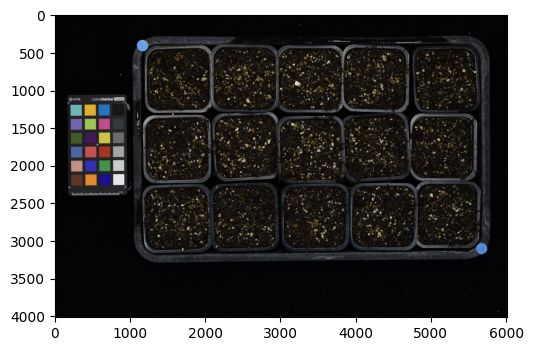

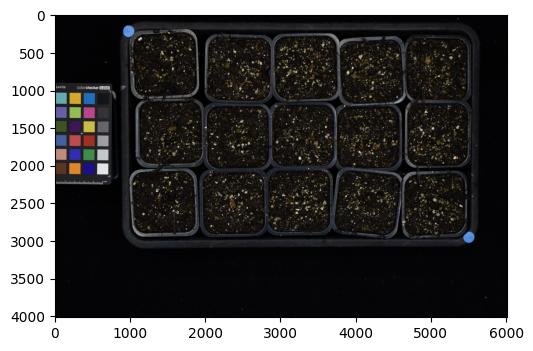

In [3]:
# resize image if made with a different camera
if img.shape[1] == 5504:
    img = img[0:0+3096, 0:0+4638]
    ref_img = imutils.resize(ref_img, width=4638)

pcv.plot_image(img)
pcv.plot_image(ref_img)

In [4]:
%%capture

df, start, space = pcv.transform.find_color_card(rgb_img=ref_img)
ref_mask = pcv.transform.create_color_card_mask(rgb_img=ref_img, radius=10, start_coord=start, spacing=space, ncols=4, nrows=6,
                                                #exclude=[1,21,23]
                                               )

df, start, space = pcv.transform.find_color_card(rgb_img=img)
img_mask = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start, spacing=space, ncols=4, nrows=6,
                                                #exclude=[1,21,23]
                                               )

output_directory = "."

# correct colour
target_matrix, source_matrix, transformation_matrix, corrected_img = pcv.transform.correct_color(ref_img, ref_mask, img, img_mask, output_directory)

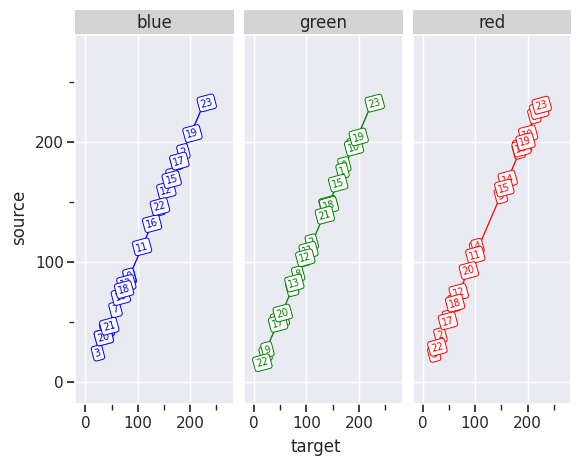

<ggplot: (8747115230584)>


In [5]:
# check that the colour correction worked (source~target should be strictly linear)
pcv.transform.quick_color_check(source_matrix = source_matrix, target_matrix = target_matrix, num_chips = 24)
pcv.print_image(img_mask, "img_mask.png")
pcv.print_image(ref_mask, "ref_mask.png")
pcv.print_image(corrected_img, "corrected_img.png")

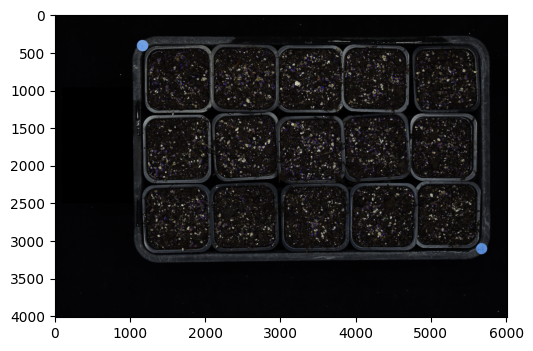

In [13]:
# write the spacing of the colour card to file as size marker   
with open(r'size_marker.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([filename, space[0]])

#x_cc,y_cc,w_cc,h_cc = cv2.boundingRect(img_mask)
#x_cc = int(round(x_cc * 1.3))
#w_cc = int(round(w_cc * 1.3))

# define a bounding rectangle around the colour card
x_cc,y_cc,w_cc,h_cc = cv2.boundingRect(img_mask)
x_cc = int(round(x_cc - 0.3 * w_cc))
y_cc = int(round(y_cc - 0.3 * h_cc))
h_cc = int(round(h_cc * 1.6))
w_cc = int(round(w_cc * 1.6))

# Crop out colour card
start_point = (x_cc, y_cc)
end_point = (x_cc+w_cc, y_cc+h_cc)
colour = (0, 0, 0)
thickness = -1
crop_img = cv2.rectangle(corrected_img, start_point, end_point, colour, thickness)

pcv.plot_image(crop_img)

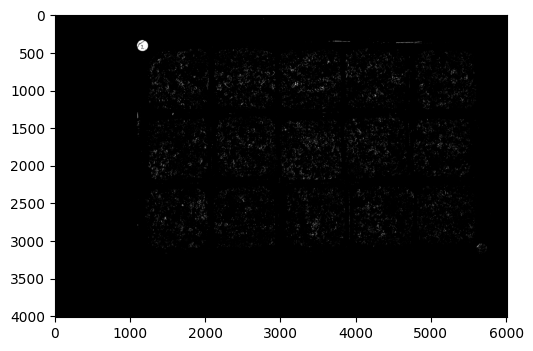

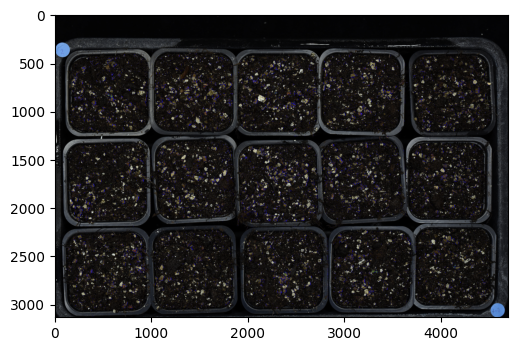

In [14]:
    #Crop tray
    #Convert RGB to HSV and extract the value channel
    v = pcv.rgb2gray_hsv(crop_img, "v")
    # Threshold the value image
    v_thresh = pcv.threshold.binary(v, 220, 255, "light")
    #v_mblur = pcv.median_blur(v_thresh, 10)
    #roi_contour, roi_hierarchy = pcv.roi.from_binary_image(img=img, bin_img=v_thresh)
    #crop_img = pcv.auto_crop(img, id_objects[0], 20, 20, 'black')
   
    x,y,w,h = cv2.boundingRect(v_thresh)
    #box = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    #cv2.drawContours(img,[box],0,(0,0,255),2)
    #roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=x+w_cc, y=y, h=h, w=w-w_cc-space[1]*2)
    #print(roi_contour)
    #crop_img = img[tuple(roi_contour)]
    #crop_img = img[y:y+h, x+w_cc:x+w-space[1]*2]
    short_w = w - (w * 0.05)
    crop_img = crop_img[y:y+h, x:x+int(w)]
    
    #crop_img = imutils.resize(crop_img, width=4500)
    
    
    #rect = cv2.minAreaRect(v_mblur)
    #box = cv2.boxPoints(rect)
    #box = np.int0(box)
    
    pcv.plot_image(crop_img)
    

In [8]:
    # Convert RGB to HSV and extract the hue channel
    #h = pcv.rgb2gray_hsv(crop_img, "h")

In [9]:
    # Threshold the hue image
    #h_thresh1_1 = pcv.threshold.binary(h, 10, 255, "light")
    #h_thresh1_2 = pcv.threshold.binary(h, 80, 255, "dark")
    #h_thresh1 = pcv.logical_and(h_thresh1_1, h_thresh1_2)
    #h_thresh2_1 = pcv.threshold.binary(h, 125, 255, "light")
    #h_thresh2_2 = pcv.threshold.binary(h, 170, 255, "dark")
    #h_thresh2 = pcv.logical_and(h_thresh2_1, h_thresh2_2)
    
    #h_thresh = pcv.logical_or(h_thresh1, h_thresh2)

In [10]:
    # Median Blur
    #h_mblur = pcv.median_blur(h_thresh, 5)
    #h_cnt = pcv.median_blur(h_thresh, 5)

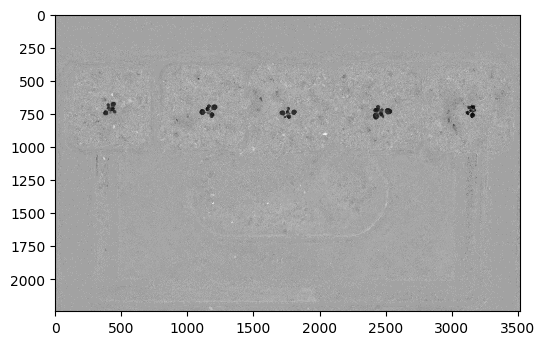

In [11]:
    # Convert RGB to LAB and extract the a channel
    a = pcv.rgb2gray_lab(crop_img, "a")
    #pcv.print_image(a, "a_channel.png")

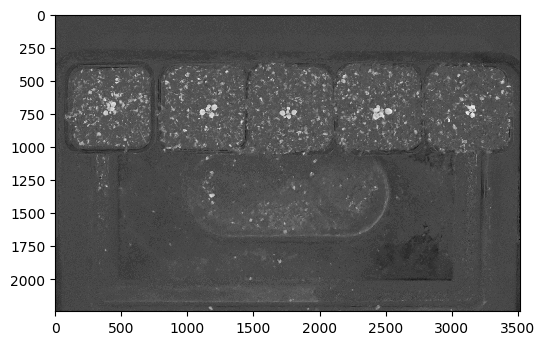

In [12]:
    # Convert RGB to LAB and extract the b channel
    b = pcv.rgb2gray_lab(crop_img, "b")
    #pcv.print_image(b, "b_channel.png")

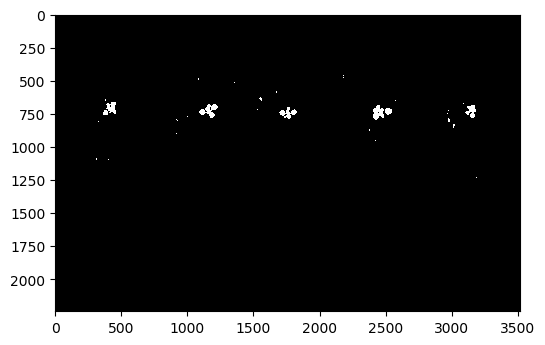

In [13]:
    # Threshold the blue image
    a_thresh = pcv.threshold.binary(a, 120, 255, "dark")
    #a_cnt = pcv.threshold.binary(a, 115, 255, "dark")
    #pcv.print_image(a_cnt, "a_cnt.png")

In [14]:
   # Join the thresholded saturation and blue-yellow images
   # commented out, hue method too insensitive here
    #bh = pcv.logical_or(h_mblur, b_cnt)
    #ah = a_cnt

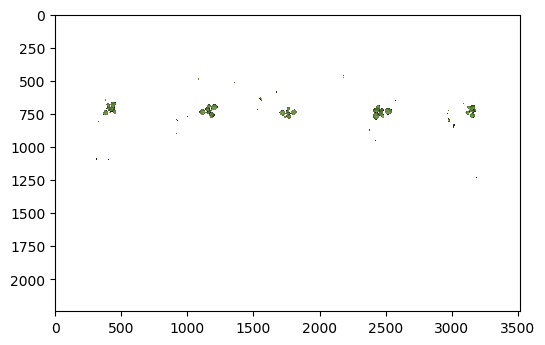

In [15]:
    # Apply Mask (for VIS images, mask_color=white)
    masked = pcv.apply_mask(crop_img, a_thresh, "white")
    pcv.print_image(masked, "pre_masked.png")

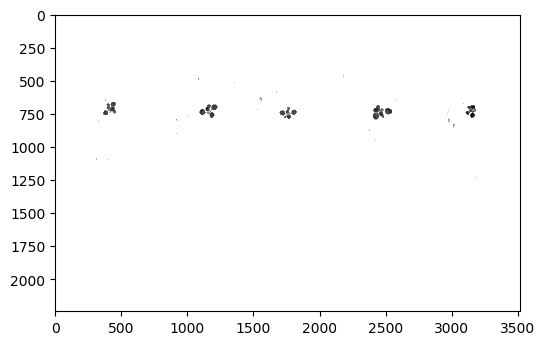

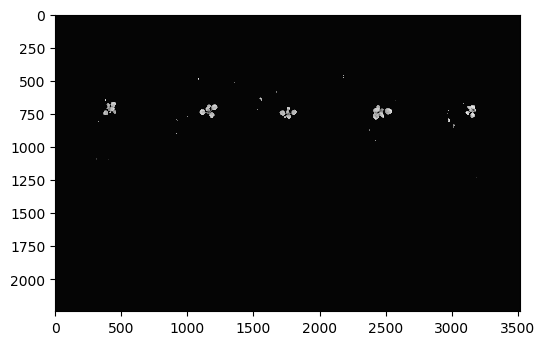

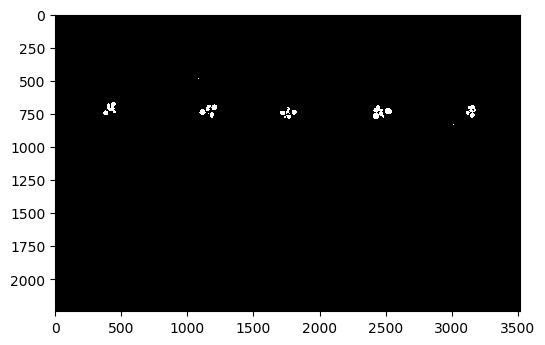

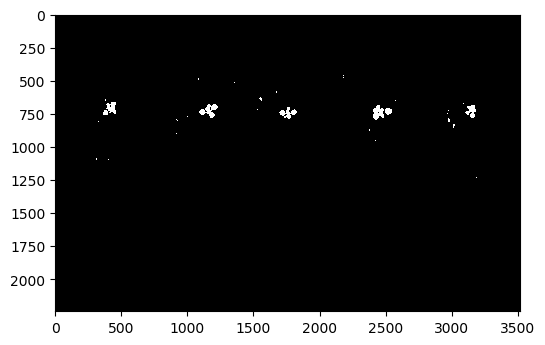

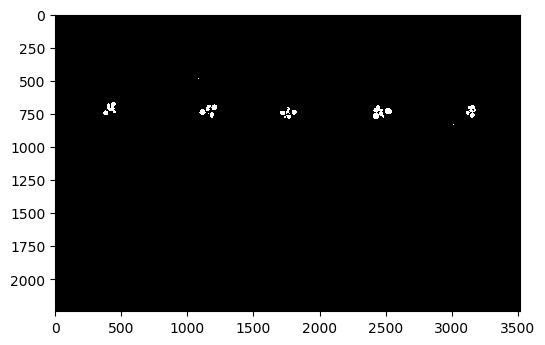

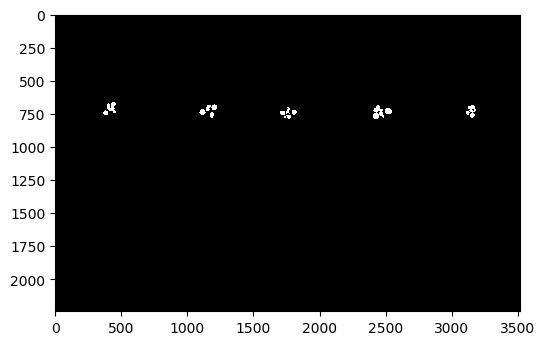

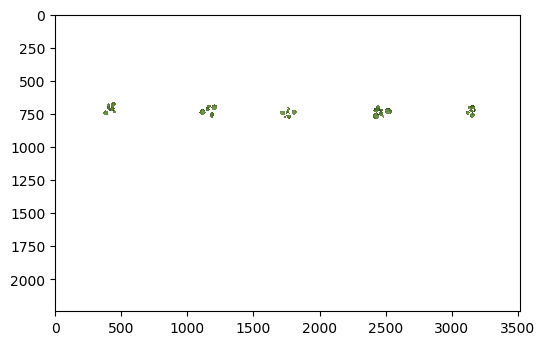

In [16]:

    # Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
    masked_a = pcv.rgb2gray_lab(masked, "a")
    masked_b = pcv.rgb2gray_lab(masked, "b")

    # Threshold the green-magenta and blue images
    maskeda_thresh = pcv.threshold.binary(masked_a, 112, 255, "dark")
    #maskeda_thresh1 = pcv.threshold.binary(masked_a, 135, 255, "light")
    maskedb_thresh = pcv.threshold.binary(masked_b, 130, 255, "light")

    # Join the thresholded saturation and blue-yellow images (OR)
    #ab1 = pcv.logical_or(maskeda_thresh, maskeda_thresh1)
    ab = pcv.logical_and(maskedb_thresh, maskeda_thresh)

    # Fill small objects
    ab_fill = pcv.fill(ab, 250)

    # Apply mask (for VIS images, mask_color=white)
    masked2 = pcv.apply_mask(masked, ab_fill, "white")

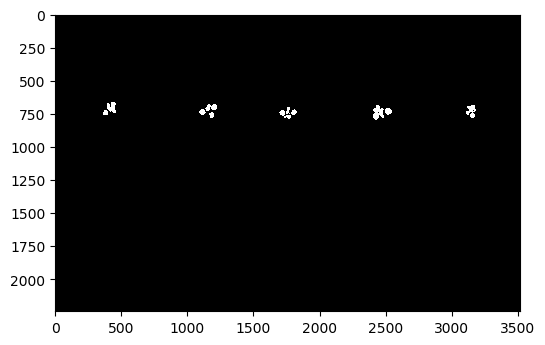

In [17]:
# STEP 8: Dilate so that you don't lose leaves (just in case)
# Inputs:
#    img    = input image
#    kernel = integer
#    i      = iterations, i.e. number of consecutive filtering passes

dilated = pcv.dilate(ab_fill, 3, 1)
pcv.print_image(dilated, "dilated.png")

In [18]:
# STEP 9: Find objects (contours: black-white boundaries)
# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection

id_objects, obj_hierarchy = pcv.find_objects(crop_img, dilated)

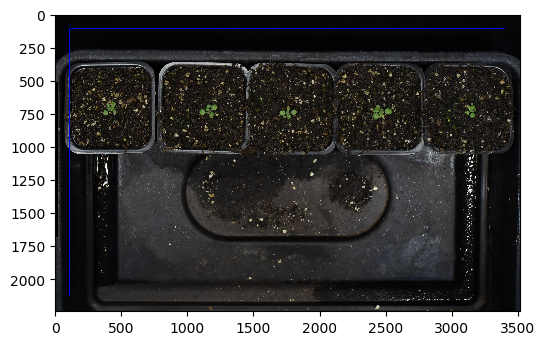

In [19]:
# STEP 10: Define region of interest (ROI)
# Inputs:
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    w     = The height of the rectangle.
#    h     = The width of the rectangle.
#    img   = An RGB or grayscale image to plot the ROI on.
#    roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1)                                                ^                ^
#                                                  |______________|
#                                            adjust these four values

roi_y = 0 + crop_img.shape[0] * 0.05
roi_x = 0 + crop_img.shape[0] * 0.05
roi_h = crop_img.shape[0] - (crop_img.shape[0] * 0.1)
roi_w = crop_img.shape[1] - (crop_img.shape[0] * 0.1)
roi_contour, roi_hierarchy = pcv.roi.rectangle(crop_img, roi_y, roi_x, roi_h, roi_w)

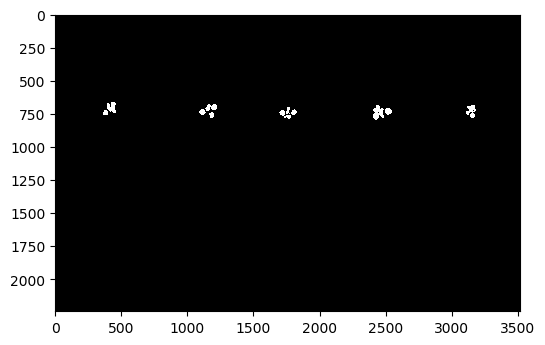

In [20]:
# STEP 12: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img = crop_img, 
                                                                      roi_type = 'partial', 
                                                                      roi_contour = roi_contour,
                                                                      roi_hierarchy = roi_hierarchy, 
                                                                      object_contour = id_objects, 
                                                                      obj_hierarchy = obj_hierarchy)

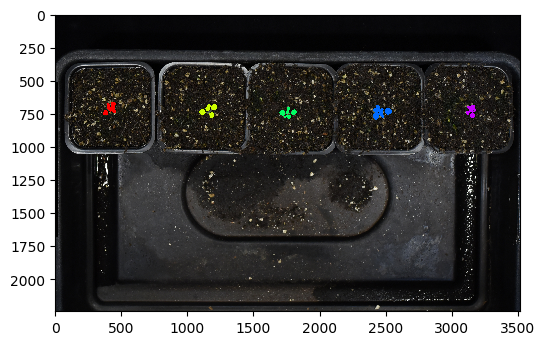

In [29]:
# STEP 13: This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of desired columns in the entire image even if there isn't a literal row of plants)

if re.search("3\.jpg$", filename):
    clusters, contours, hierarchies = pcv.cluster_contours(crop_img, roi_objects, roi_obj_hierarchy, 1, 5)
else: 
    clusters, contours, hierarchies = pcv.cluster_contours(crop_img, roi_objects, roi_obj_hierarchy, 3, 5)

In [22]:
%%capture
# STEP 14: This #function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered
# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
# Un-comment the line below to see the split up contours print to the output directory 
#pcv.params.debug = "print"

#out = args.outdir

# If you have a list of treatments, genotypes, etc. You would input a .txt file with them to help save
# the contours by names, add it to the options class and then add filenames=names to the 
# splitimg function below.  
#names = args.names

output_path, imgs, masks = pcv.cluster_contour_splitimg(crop_img, clusters, contours, 
                                           hierarchies, ".", file=filename)

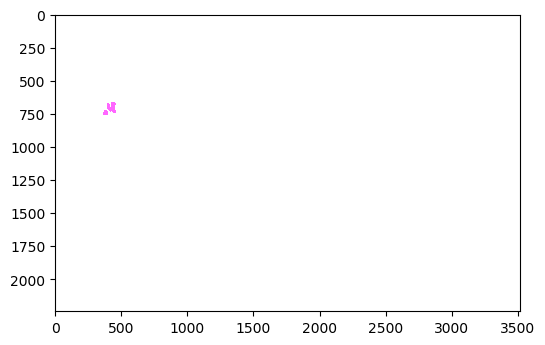

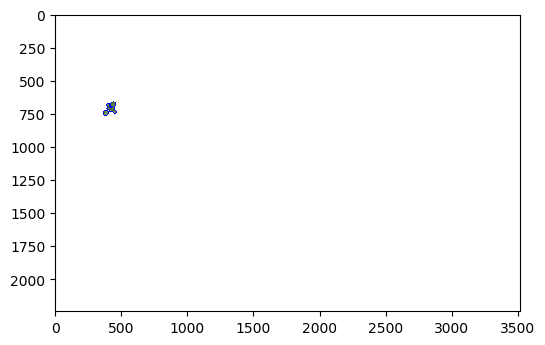

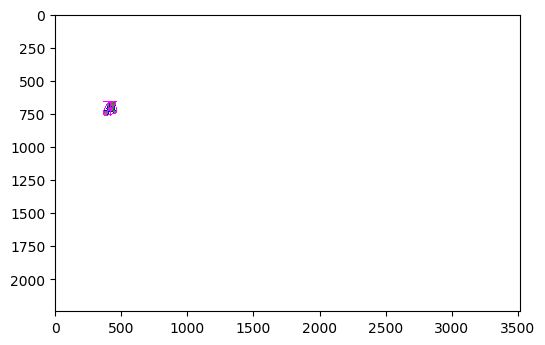

<ggplot: (8764597793969)>


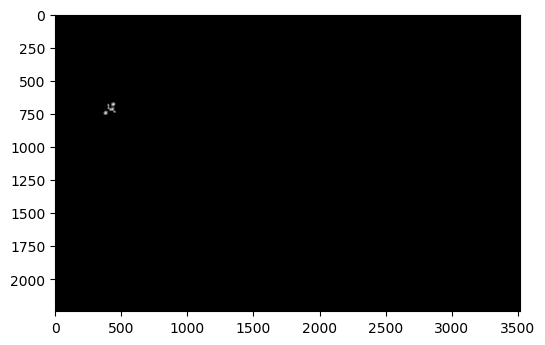

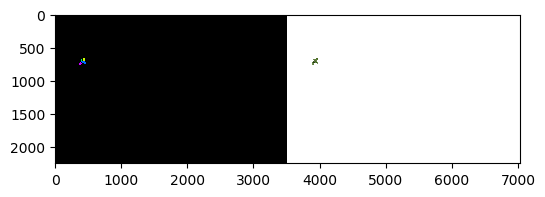

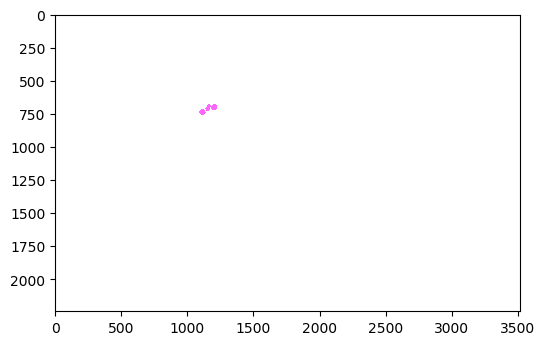

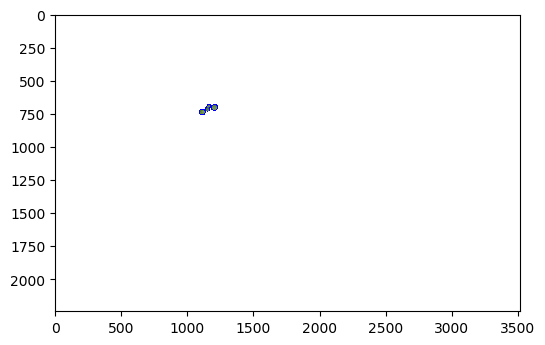

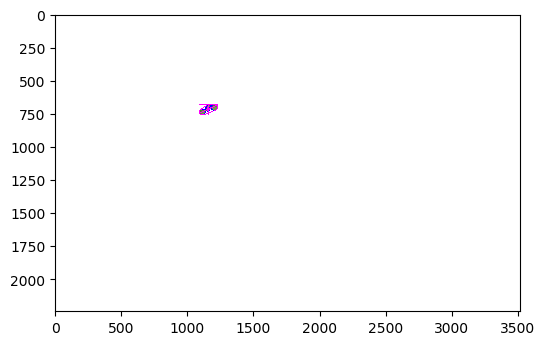

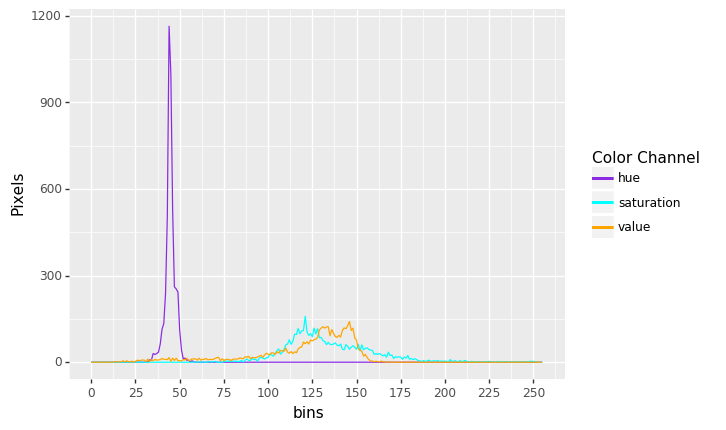

<ggplot: (8764597445169)>


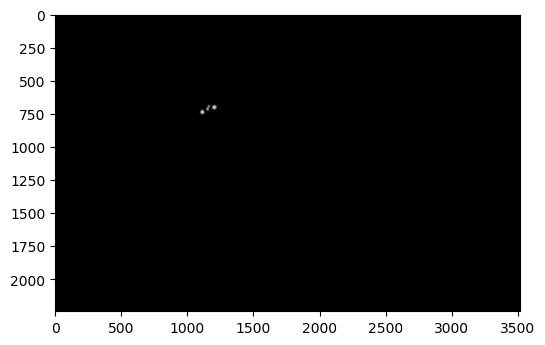

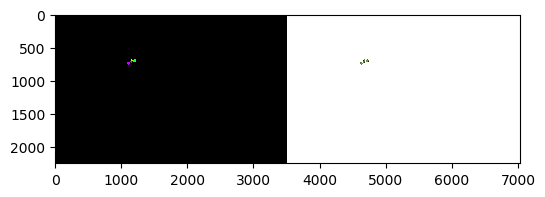

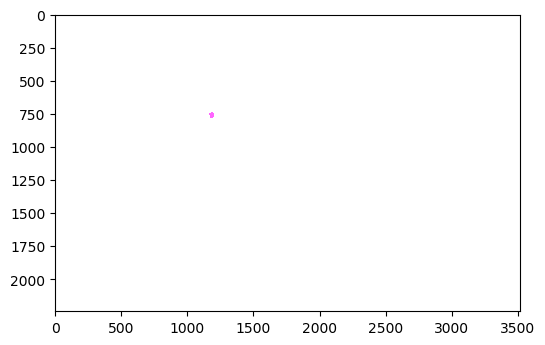

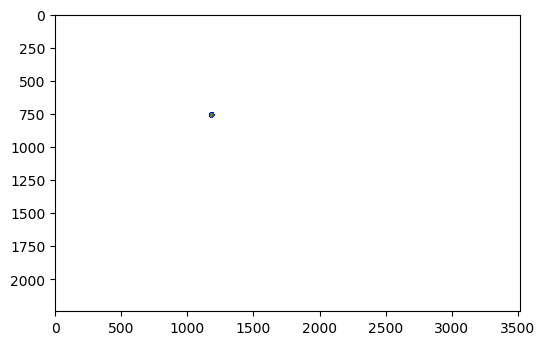

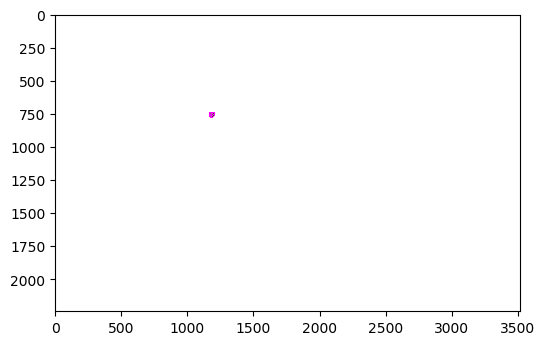

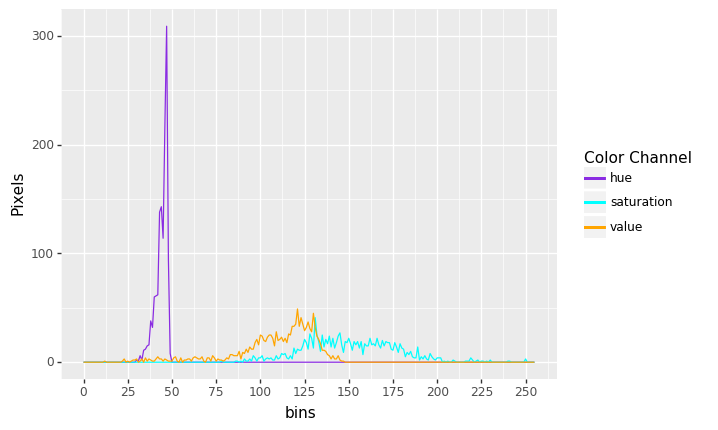

<ggplot: (8764597679705)>


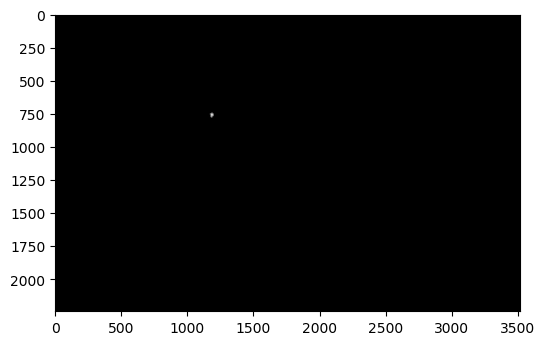

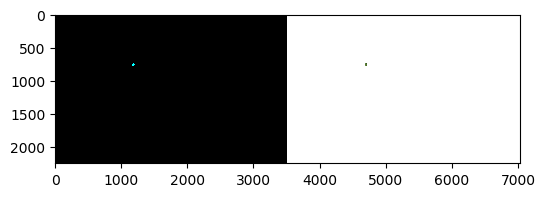

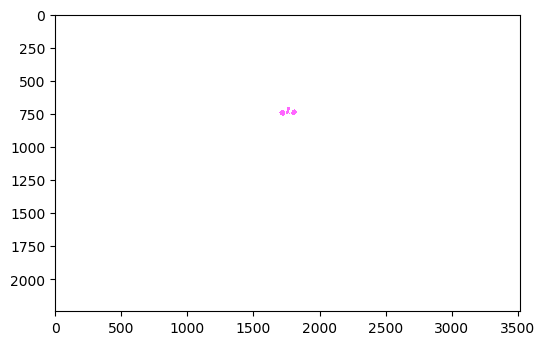

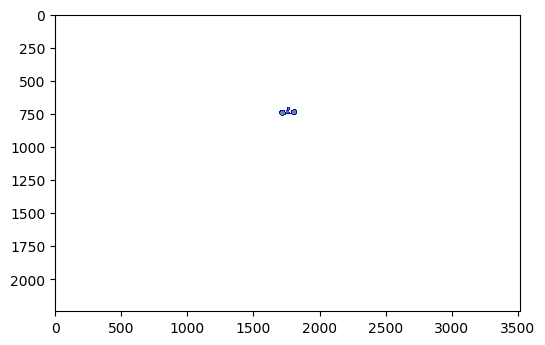

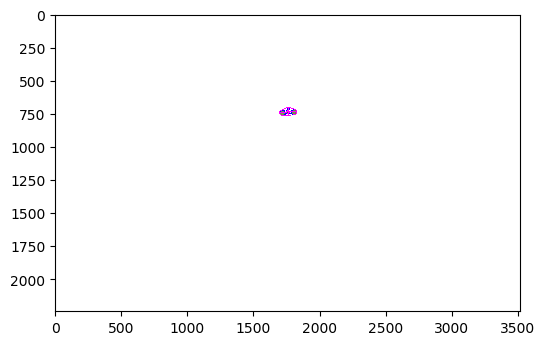

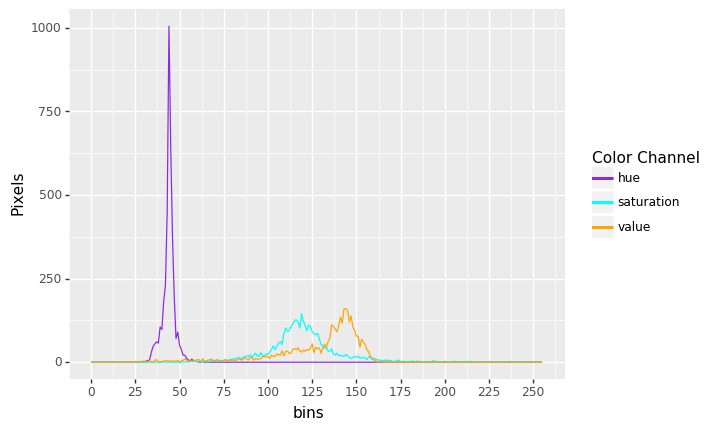

<ggplot: (8764597541317)>


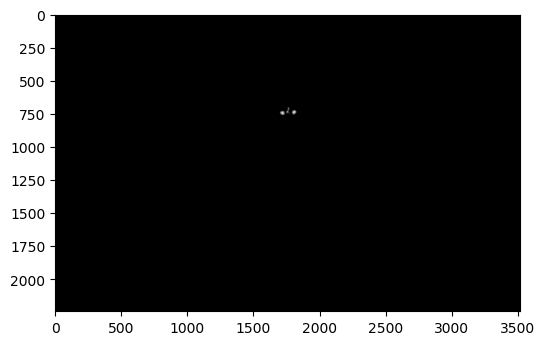

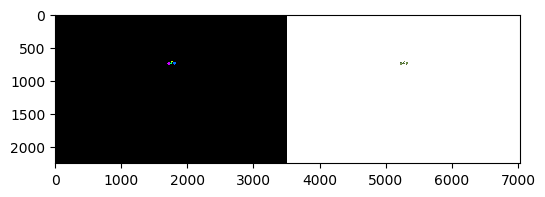

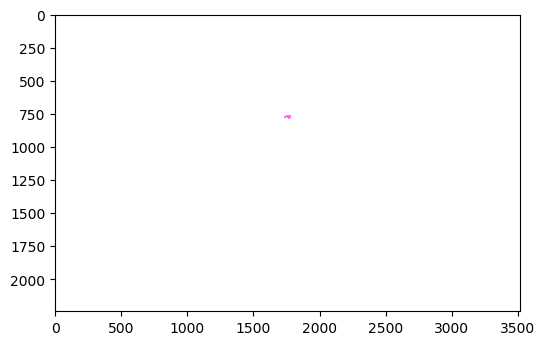

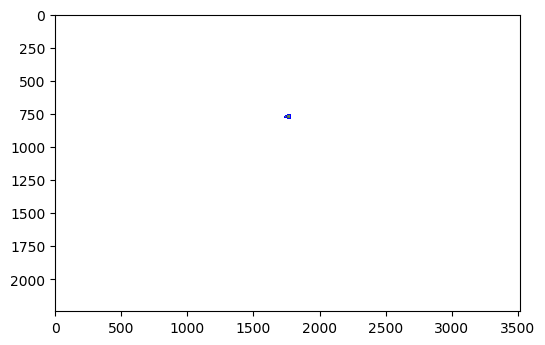

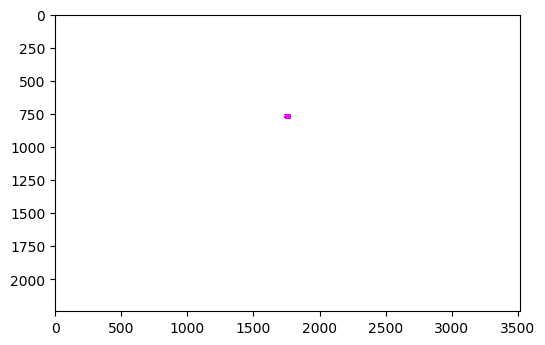

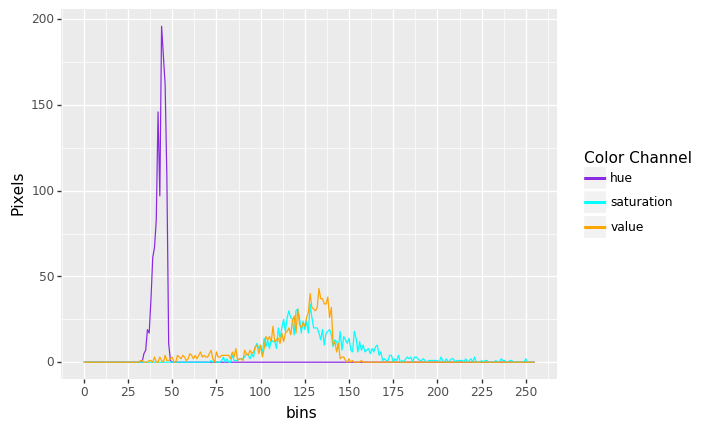

<ggplot: (8764599406753)>


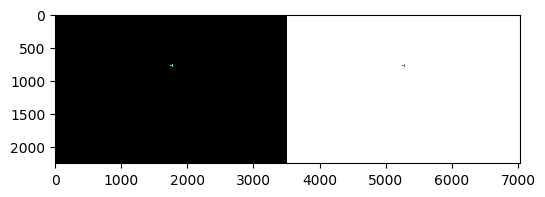

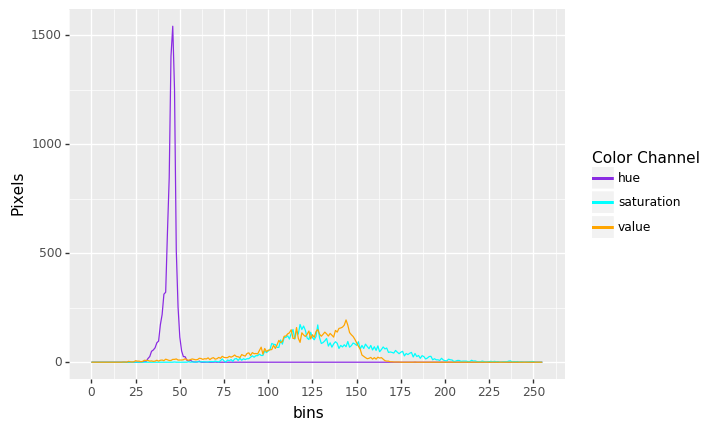

<ggplot: (8764597770237)>


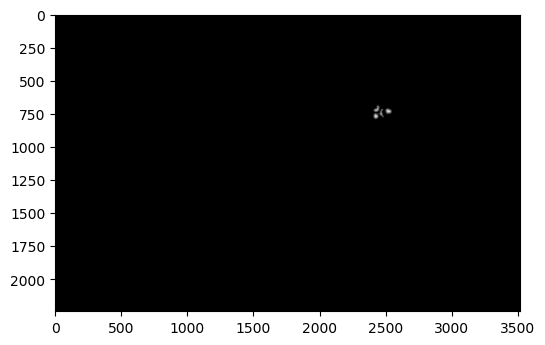

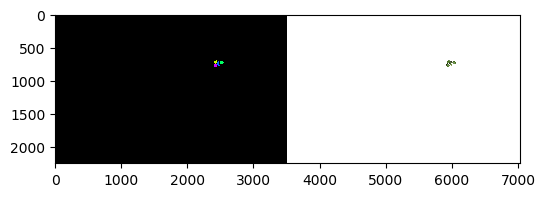

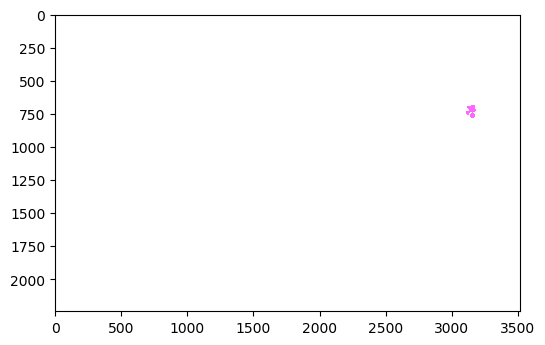

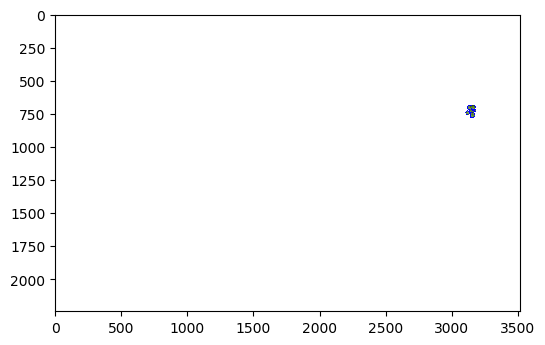

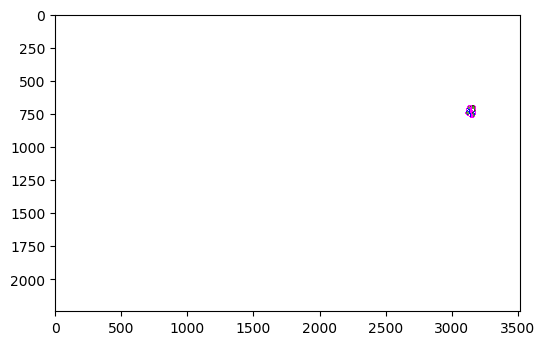

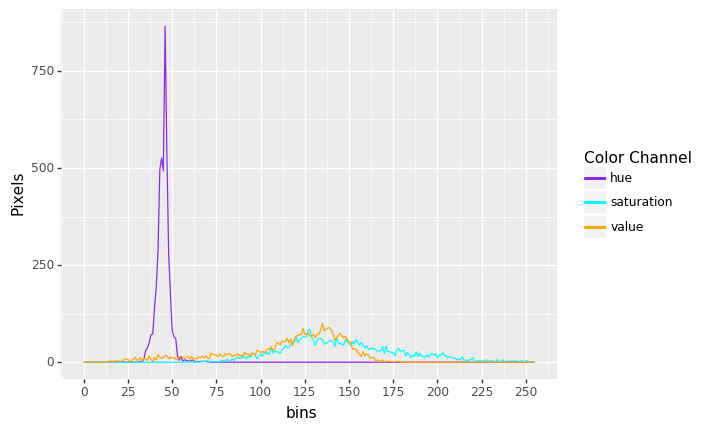

<ggplot: (8764597716105)>


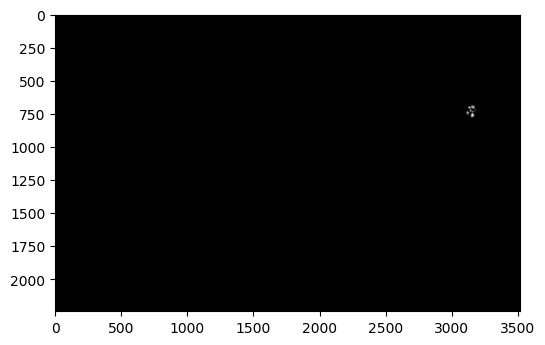

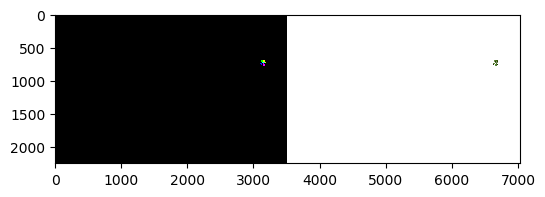

In [23]:
for i in range(0, len(imgs)):              
        contours, hierarchy = pcv.find_objects(imgs[i], masks[i])
        obj, mask = pcv.object_composition(imgs[i], contours, hierarchy)
        
        # Analyze the shape of each plant 
        analysis_images = pcv.analyze_object(img=imgs[i], obj=obj, mask=masks[i])

        # Determine color properties: Histograms, Color Slices, output color analyzed histogram (optional)
        color_images = pcv.analyze_color(imgs[i], masks[i], "hsv")

        # Watershed plant area to count leaves
        watershed_images = pcv.watershed_segmentation(imgs[i], masks[i], 15)

        # Save the image with shape characteristics 
        #img_copy = analysis_images[0]

        # Print out a text file with shape data for each plant in the image 
        pcv.print_results(filename = filename + "_" + str(i) + '.json')
        # Clear the measurements stored globally into the Ouptuts class
        # results.append(watershed_header, watershed_data)
        #print(pcv.outputs.observations)
        #pcv.print_image(analysis_images, filename)
        pcv.outputs.clear()